# Определение стоимости автомобилей

В целях привлечения новых клиентов сервис по продаже автомобилей с пробегом
разрабатывает приложение для расчёта рыночной стоимости автомобиля
Необходимо построить модель, которая будет определять стоимость автомобиля по его характеристикам

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from category_encoders.binary import BinaryEncoder
from sklearn.metrics import mean_squared_error, make_scorer

pd.options.mode.chained_assignment = None

def df_common_info(df):
    """
    Выводит общую информацию по датафрейму
    """
    display(df.head())
    
    print("\nОбщая информация:")
    display(df.info())
    display(df.shape)
    display(df.columns)
    
    
    print('\nСтатистики:')
    display(df.describe(include=['float', 'int']).T)
    
    print('\nДубликаты:')
    display(df.duplicated().sum())
    display(df[df.duplicated()])
    
    return

In [2]:
data = pd.read_csv("../datasets/autos.csv")
df_common_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes

None

(354369, 16)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')


Статистики:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Дубликаты:


4

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


**Вывод:**
* Необходимо удалить полные дубликаты
* Столбцы VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired - необходимо проверить на неявные дубликаты
* В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired - пропуски 
* В столбце NumberOfPictures только 0 - удалим этот столбец
* Столбцы DateCrawled, LastSeen - не влияют на модель - удалим эти столбцы.
* Столбец RegistrationYear, Power, RegistrationMonth - есть выбросы
* Признак PostalCode - категориальный, но столбец имеет числовой тип, необходимо его преобразовать

### Обработка пропусков и дубликатов

Удалим явные дубликаты

In [3]:
print('Было строк: ', data.shape[0])

data = data.drop_duplicates()
print('Осталось строк: ', data.shape[0])

Было строк:  354369
Осталось строк:  354365


#### Столбец VehicleType

In [4]:
print(data['VehicleType'].unique())
data['VehicleType'].isna().mean()

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


0.10579487251844849

* Неявных дубликатов нет
* Пропусков около 10%. Довольно много, поэтому удалять пропуски не будем, а заполним их. Поскольку машины одной модели могут выпускаться с разным кузовом, заполним пропуски новым значением 'unknown'. Использовать значение 'other'не будем, поскольку 'other' подразумевает, значение отличное от предложенных ('coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon')

In [5]:
data['VehicleType'].fillna('unknown', inplace=True)

#### Столбец Gearbox

In [6]:
print(data['Gearbox'].unique())
data['Gearbox'].isna().mean()

['manual' 'auto' nan]


0.05596771690206426

* Неявных дубликатов нет
* Пропусков около 5%. Довольно много, поэтому удалять пропуски не будем, а заполним их значением 'unknown'

In [7]:
data['Gearbox'].fillna('unknown', inplace=True)

#### Столбец Model

In [8]:
print(data['Model'].unique())
data['Model'].isna().mean()

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

0.05560650741467131

* Неявных дубликатов нет
* Пропусков около 5%. Довольно много, поэтому удалять пропуски не будем, а заполним их значением 'unknown'

In [9]:
data['Model'].fillna('unknown', inplace=True)

#### Столбец FuelType

In [10]:
print(data['FuelType'].unique())
data['FuelType'].isna().mean()

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


0.09282801631086592

* Неявных дубликатов нет
* Пропусков около 9%. Довольно много, поэтому удалять пропуски не будем, а заполним их значением 'unknown'

In [11]:
data['FuelType'].fillna('unknown', inplace=True)

#### Столбец Repaired

In [12]:
print(data['Repaired'].unique())
data['Repaired'].isna().mean()

[nan 'yes' 'no']


0.2007929677027923

* Неявных дубликатов нет
* Пропусков около 2%. Удалять пропуски не будем, а заполним их значением 'unknown'

In [13]:
data['Repaired'].fillna('unknown', inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

**Вывод:** Пропусков в данных нет

#### Столбец RegistrationYear

In [15]:
data['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

В данном столбце есть аномальные значения. Отсечём их по 99процентилю

In [16]:
data = data[(data['RegistrationYear'] < data['RegistrationYear'].quantile(.99)) & (data['RegistrationYear'] > data['RegistrationYear'].quantile(.01))]
data['RegistrationYear'].describe()

count    346236.000000
mean       2003.295021
std           6.394669
min        1981.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2017.000000
Name: RegistrationYear, dtype: float64

Аномальные значения отфильтрованы. Удалим записи, где год создания объявления меньше, чем год регистрации авто.

In [17]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')

print('Количество удаленных записей:', 
      len(data.query("DateCreated.dt.year < RegistrationYear")))

data = data.drop(data.query("DateCreated.dt.year < RegistrationYear").index)

Количество удаленных записей: 10441


In [18]:
data['RegistrationYear'].describe()

count    335795.000000
mean       2002.868887
std           6.011780
min        1981.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

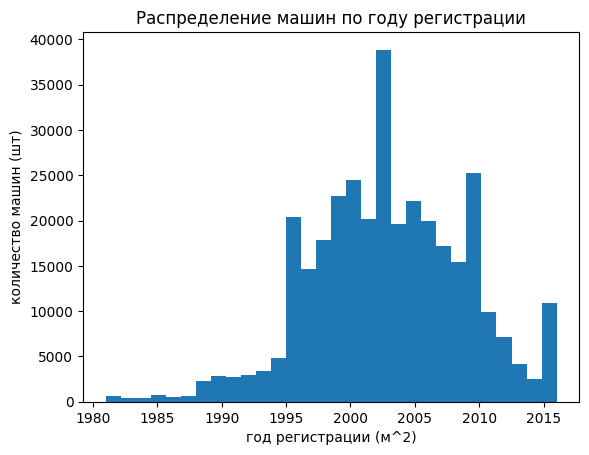

In [19]:
data.plot(
    kind='hist',
    y='RegistrationYear',
    bins = 30,
    legend=False
)
plt.title("Распределение машин по году регистрации", fontsize=12)
plt.xlabel("год регистрации (м^2)")
plt.ylabel("количество машин (шт)")
plt.show()

Распределение похоже на нормальное, подозрительных всплесков нет

#### Столбец Power

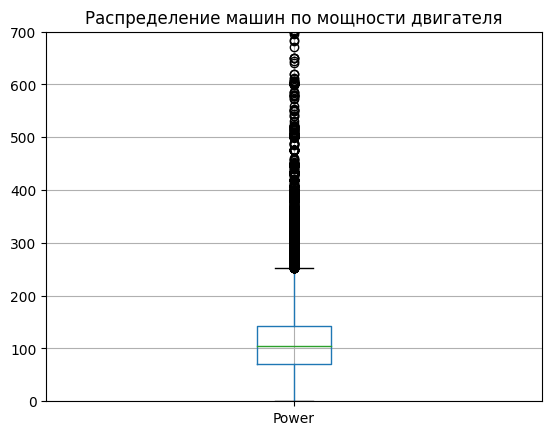

In [20]:
data.boxplot('Power') 
plt.ylim(0, 700)
plt.title("Распределение машин по мощности двигателя", fontsize=12)
plt.show()

Посмотрим долю автомобилей с мощностью двигателя свыше 300

In [21]:
len(data.query('Power > 300')) / len(data)

0.00988996262600694

Таких машин мало (0.9%). Удалим эти строки.

In [22]:
data = data.drop(data.query('Power > 300').index)

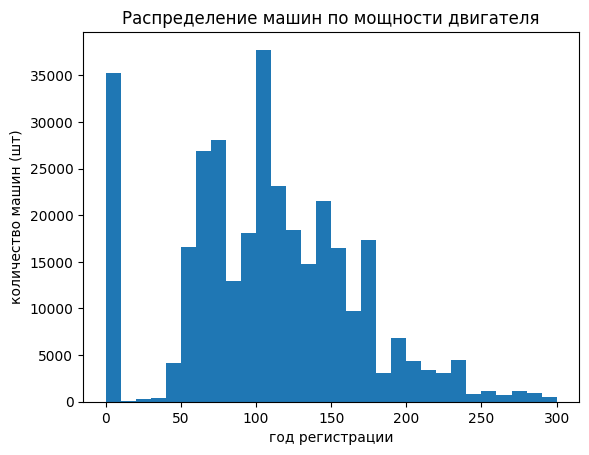

In [23]:
data.plot(
    kind='hist',
    y='Power',
    bins = 30,
    legend=False
)
plt.title("Распределение машин по мощности двигателя", fontsize=12)
plt.xlabel("год регистрации")
plt.ylabel("количество машин (шт)")
plt.show()

Заметен скачок автомобилей с мощностью 0, скорее всего это автомобили с неуказанной мощностью. Удалим записи с мощностью меньше 40

In [24]:
print('Количество удаленных строк:', len(data.query('Power < 40')))
data = data.drop(data.query('Power < 40').index)

Количество удаленных строк: 36039


**Вывод:** 
* Удалено 4 полных дубликата
* Неявных дубликатов не обнаружено
* В столбцах VehicleType, Gearbox, Model, FuelType, Repaired пропусков довольно много,корректно восстановить их не возможно, поэтому заполнили значениями 'unknown'
* Удалены аномалии в RegistrationYear. В результате остались строки с годом регистрации от 1981 по 2016.
* Удалены строки со значениями в столбце Power выше 300 и ниже 40. Таких строк немного около 0.9%, поэтому они существенно на модели не повлияют

Всего удалено около 16% строк

## Простые модели

### Подготовка признаков

#### Отбор признаков влияющих на модель

Удалим столбцы NumberOfPictures, DateCrawled, LastSeen, DateCreated, RegistrationMonth т.к. они не влияют на стоимость

In [25]:
data = data.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth'], axis=1)
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'PostalCode'],
      dtype='object')

Посмотрим количество значений в столбце PostalCode

In [26]:
data['PostalCode'].nunique()

8115

PostalCode - категориальный признак, значений много (8141), закодировать техникой OHE не получится. Поэтому удалим этот столбец.

In [27]:
data = data.drop(columns=['PostalCode'])

Посмотрим нет ли линейной зависимости между количественными признаками

In [28]:
data.corr()

C:\Users\User\AppData\Local\Temp\ipykernel_1568\1185648202.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.579720,0.495186,-0.395817
RegistrationYear,0.579720,1.000000,0.141211,-0.376468
Power,0.495186,0.141211,1.000000,0.094803
Kilometer,-0.395817,-0.376468,0.094803,1.000000


Линейной зависимости между признаками нет

#### Выделение целевого признака

In [29]:
features = data.drop(['Price'], axis=1)
target = data['Price']

#### Разбиение данных на тестовую и обучающую выборку

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

print('Размер обучающей выборки:', len(features_train))
print('Размер тестовой выборки:', len(features_test))

Размер обучающей выборки: 222326
Размер тестовой выборки: 74109


#### Масштабирование количественных признаков

In [31]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### Кодирование категориальных признаков

In [32]:
print('VehicleType:', data.VehicleType.nunique())
print('Gearbox:', data.Gearbox.nunique())
print('Model: ', data.Model.nunique())
print('Brand: ', data.Brand.nunique())
print('NotRepaired:', data.Repaired.nunique())

VehicleType: 9
Gearbox: 3
Model:  249
Brand:  40
NotRepaired: 3


Признаки 'FuelType', 'VehicleType', 'Gearbox', 'Repaired', закодируем техникой OHE, поскольку у этих признаков не много уникальных значений

In [33]:
features_train = pd.get_dummies(features_train, drop_first=True, columns=['FuelType', 'VehicleType', 'Gearbox', 'Repaired'])
print('Количество признаков в обучающей выборке:', features_train.shape[1])

features_test = pd.get_dummies(features_test, drop_first=True, columns=['FuelType', 'VehicleType', 'Gearbox', 'Repaired'])
print('Количество признаков в тестовой выборке:', features_train.shape[1])


Количество признаков в обучающей выборке: 24
Количество признаков в тестовой выборке: 24


Признаки 'Model', 'Brand' закодируем при помощи BinaryEncoder, поскольку много уникальных значений

In [34]:
bn = BinaryEncoder()
df_tmp = bn.fit_transform(features_train[['Model','Brand']])
features_train = pd.concat([features_train, df_tmp], axis=1)
features_train = features_train.drop(['Model','Brand'], axis=1)
print('Количество признаков в обучающей выборке:', features_train.shape[1])

df_tmp = bn.transform(features_test[['Model','Brand']])
features_test = pd.concat([features_test, df_tmp], axis=1)
features_test = features_test.drop(['Model','Brand'], axis=1)
print('Количество признаков в тестовой выборке', features_test.shape[1])


Количество признаков в обучающей выборке: 36
Количество признаков в тестовой выборке 36


**Вывод:** 
* Удалены признаки NumberOfPictures, DateCrawled, LastSeen, 'RegistrationMonth', DateCreated и PostalCode
* Выделен целевой признак
* Данные разбиты на обучающую и тестовую выборку в соотношении
* Количественные признаки 'RegistrationYear', 'Power', 'Kilometer' масштабированы
* Категориальные признаки 'FuelType', 'VehicleType', 'Gearbox', 'Repaired', закодированы техникой OHE
* Категориальные признаки 'Model', 'Brand' закодированы при помощи BinaryEncoder

### Подбор параметров моделей

In [35]:
def rMSE(y_true, y_pred, **kwargs):
    return mean_squared_error(y_true, y_pred) ** 0.5

rMSE_scorer = make_scorer(rMSE, greater_is_better=False)

#### Линейная регрессия

In [36]:
%%time
model = LinearRegression()

mean_rmse = -cross_val_score(model, features_train, target_train, scoring=rMSE_scorer, cv=5).mean()
print("Усреднённое RMSE модели:", mean_rmse)

Усреднённое RMSE модели: 2635.870355836115
CPU times: total: 3.81 s
Wall time: 1.81 s


Усреднённое RMSE модели: 2635

#### Дерево решений

In [38]:
model = DecisionTreeRegressor(random_state=1234)
parameters = {'max_depth': range (1, 20, 2)}

grid = GridSearchCV(model, parameters, scoring = rMSE_scorer, cv=5)
grid.fit(features_train, target_train)

print('Лучшие параметры', grid.best_params_)
print('Усредненное RMSE:', -grid.best_score_)

Лучшие параметры {'max_depth': 15}
Усредненное RMSE: 1897.97904668009


Лучшее усредненное значение RMSE на тестовой выборке достигается при параметрах {'max_depth': 13} и равняется 1898

#### Случайный лес

In [39]:
model = RandomForestRegressor(random_state=1234)
parameters = {'n_estimators': range (30, 80, 10), 'max_depth': range (10, 15, 2)}
grid = GridSearchCV(model, parameters, scoring = rMSE_scorer, cv=5, verbose=10)
grid.fit(features_train, target_train)

print('Лучшие параметры', grid.best_params_)
print('RMSE', -grid.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=10, n_estimators=30..............................
[CV 1/5; 1/15] END max_depth=10, n_estimators=30;, score=-1885.540 total time=  11.8s
[CV 2/5; 1/15] START max_depth=10, n_estimators=30..............................
[CV 2/5; 1/15] END max_depth=10, n_estimators=30;, score=-1923.526 total time=  10.9s
[CV 3/5; 1/15] START max_depth=10, n_estimators=30..............................
[CV 3/5; 1/15] END max_depth=10, n_estimators=30;, score=-1920.007 total time=  10.9s
[CV 4/5; 1/15] START max_depth=10, n_estimators=30..............................
[CV 4/5; 1/15] END max_depth=10, n_estimators=30;, score=-1906.758 total time=  10.8s
[CV 5/5; 1/15] START max_depth=10, n_estimators=30..............................
[CV 5/5; 1/15] END max_depth=10, n_estimators=30;, score=-1890.839 total time=  11.0s
[CV 1/5; 2/15] START max_depth=10, n_estimators=40..............................
[CV 1/5; 2/15] END max_

Лучшее усреднённое значение RMSE достигается при параметрах {'max_depth': 14, 'n_estimators': 70} и равняется 1684

**Вывод:**
* Для модели Линейная регрессия RMSE на тестовой выборке равен 2638
* Для модели Решающее дерево Лучшее усредненное значение RMSE на тестовой выборке достигается при параметрах {'max_depth': 13} и равен 1898
* Для модели Случайный лес лучшее усредненное значение RMSE на тестовой выборке достигается при параметрах {'max_depth': 14, 'n_estimators': 70} и равен 1684

## Модели градиентного бустинга

### Подготовка признаков

Приведем категориальные признаки к типу category

In [42]:
boost_features = features.astype({
    'FuelType': 'category', 
    'VehicleType': 'category', 
    'Gearbox': 'category',  
    'Repaired': 'category',
    'Model': 'category', 
    'Brand': 'category'
})

Разобьём данные на тестовую и обучающую выборки

In [43]:
boost_features_train, boost_features_test, boost_target_train, boost_target_test = train_test_split(
    boost_features, target, test_size=0.25, random_state=12345
)

print('Размер обучающей выборки:', len(boost_features_train))
print('Размер тестовой выборки:', len(boost_features_test))

Размер обучающей выборки: 222326
Размер тестовой выборки: 74109


### LGBMRegressor

Определим вспомогательные функции

In [44]:
def evaluate_model(model, X, y):
    """
    Методом кросс-валидации оценивает модель model 
    метрикой 'neg_root_mean_squared_error'
    на данных X, с целевым признаком y.
    Возвращает список оценок
    """
    print (model)
    scores = cross_val_score(model, X, y,  scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    return scores


def show_models_performance(models, X, y):
    """
    Показывает разброс метрик rMSE моделей из models.
    """
    # evaluate the models and store results
    results, names = list(), list()

    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  
    # plot model performance for comparison
    plt.boxplot(results, labels=names, showmeans=True)
    plt.show()
    return

#### Исследование скорости обучения

LGBMRegressor(learning_rate=0.0001, random_state=12345)
>0.0001 -4510.607 (20.939)
LGBMRegressor(learning_rate=0.001, random_state=12345)
>0.0010 -4224.329 (20.335)
LGBMRegressor(learning_rate=0.01, random_state=12345)
>0.0100 -2546.310 (13.882)
LGBMRegressor(random_state=12345)
>0.1000 -1620.671 (16.226)
LGBMRegressor(learning_rate=0.3, random_state=12345)
>0.3000 -1601.121 (19.356)
LGBMRegressor(learning_rate=0.5, random_state=12345)
>0.5000 -1614.362 (14.311)
LGBMRegressor(learning_rate=1.0, random_state=12345)
>1.0000 -1702.927 (15.699)


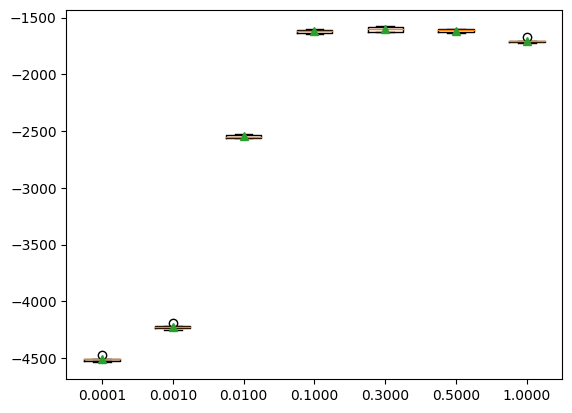

In [45]:
models = dict()
rates = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1.0]
for r in rates:
    key = '%.4f' % r
    models[key] = lgb.LGBMRegressor(random_state=12345, learning_rate=r)

show_models_performance(models, boost_features_train, boost_target_train)

**Вывод:** при learning_rate=0.3 достигается минимум метрики RMSE(1601) среди перебираемых значений 

#### Исследование количества деревьев  

LGBMRegressor(learning_rate=0.3, n_estimators=10, random_state=12345)
>10 -1765.623 (13.975)
LGBMRegressor(learning_rate=0.3, n_estimators=50, random_state=12345)
>50 -1626.371 (18.627)
LGBMRegressor(learning_rate=0.3, random_state=12345)
>100 -1601.121 (19.356)
LGBMRegressor(learning_rate=0.3, n_estimators=150, random_state=12345)
>150 -1589.528 (18.797)
LGBMRegressor(learning_rate=0.3, n_estimators=200, random_state=12345)
>200 -1583.174 (19.586)
LGBMRegressor(learning_rate=0.3, n_estimators=250, random_state=12345)
>250 -1577.478 (19.829)
LGBMRegressor(learning_rate=0.3, n_estimators=300, random_state=12345)
>300 -1573.638 (20.274)
LGBMRegressor(learning_rate=0.3, n_estimators=400, random_state=12345)
>400 -1569.722 (20.399)


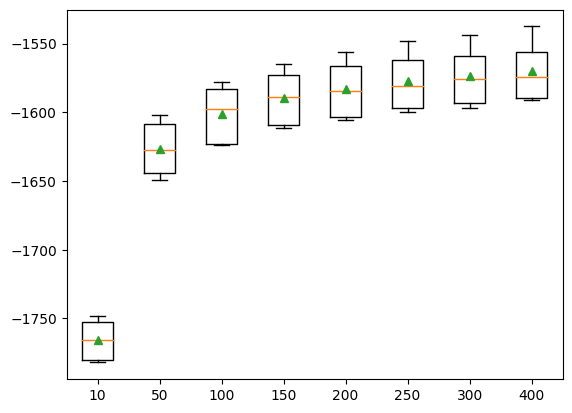

CPU times: total: 812 ms
Wall time: 22.3 s


In [46]:
%%time
models = dict()
trees = [10, 50, 100, 150, 200, 250, 300, 400]
for n in trees:
    models[str(n)] = lgb.LGBMRegressor(random_state=12345, n_estimators=n, learning_rate=0.3)

show_models_performance(models, boost_features_train, boost_target_train)

При количестве деревьев более 50 ощутимого улучшения модели не наблюдается. Дальнейшее исследование будем проводить для модели с n_estimators=150 (Усреднённое RMSE=1589)

#### Исследование глубины деревьев

LGBMRegressor(learning_rate=0.3, max_depth=1, n_estimators=150,
              random_state=12345)
>1 -2059.953 (9.335)
LGBMRegressor(learning_rate=0.3, max_depth=2, n_estimators=150,
              random_state=12345)
>2 -1752.896 (13.103)
LGBMRegressor(learning_rate=0.3, max_depth=3, n_estimators=150,
              random_state=12345)
>3 -1674.440 (14.835)
LGBMRegressor(learning_rate=0.3, max_depth=4, n_estimators=150,
              random_state=12345)
>4 -1632.278 (12.309)
LGBMRegressor(learning_rate=0.3, max_depth=5, n_estimators=150,
              random_state=12345)
>5 -1605.203 (15.734)
LGBMRegressor(learning_rate=0.3, max_depth=6, n_estimators=150,
              random_state=12345)
>6 -1595.369 (17.979)
LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=150,
              random_state=12345)
>7 -1593.019 (14.598)
LGBMRegressor(learning_rate=0.3, max_depth=8, n_estimators=150,
              random_state=12345)
>8 -1592.071 (15.961)
LGBMRegressor(learning_rate=0.3, max_dept

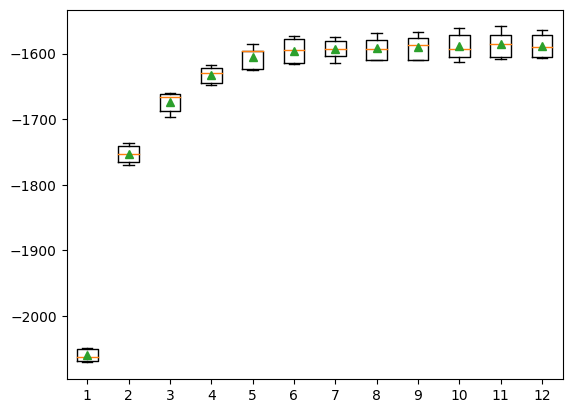

In [47]:
models = dict()
for i in range(1,13):
    models[str(i)] = lgb.LGBMRegressor(random_state=12345, n_estimators=150, max_depth=i, learning_rate=0.3)

show_models_performance(models, boost_features_train, boost_target_train)

При максимальной глубине деревьев более 8 улучшения модели не наблюдается. Таким образом выберем следующие гиперпараметры для модели LGBMRegressor следующие: learning_rate=0.3, max_depth=8, n_estimators=150. Усредненное RMSE = 1589

#### Подбор параметров через GridSearchCV

In [48]:
model_LGBM = lgb.LGBMRegressor(random_state = 12345)
lgbm_params = {'n_estimators': range(80, 170, 20),
               'max_depth': range(3, 11),
               'learning_rate': np.arange(0.1, 0.41, 0.05)
               }

grid_lgbm = GridSearchCV(estimator = model_LGBM, param_grid = lgbm_params, n_jobs = -1, scoring = rMSE_scorer, cv=5, verbose=10)
grid_lgbm.fit(boost_features_train, boost_target_train)
print(grid_lgbm.best_params_)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
{'learning_rate': 0.20000000000000004, 'max_depth': 10, 'n_estimators': 160}


In [49]:
print(grid_lgbm.best_score_)

-1586.4697600682787


GridSearchCV выдал похожие результаты: наилучшие параметры 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 160, усредненное RMSE: 1585

## Анализ моделей

### Линейная регрессия

In [50]:
%%time
model = LinearRegression() 
model.fit(features_train, target_train)

CPU times: total: 1.19 s
Wall time: 420 ms


LinearRegression()

In [51]:
%time
predictions = model.predict(features_test)
rmse =  rMSE(target_test, predictions)
print("RMSE модели на тестовой выборке:", rmse)

CPU times: total: 0 ns
Wall time: 0 ns
RMSE модели на тестовой выборке: 2638.443320533374


RMSE: 2638, время обучения: 815мс, время предсказания 9 µs

### Дерево решений

In [52]:
%%time
model = DecisionTreeRegressor(max_depth=13, random_state=1234)
model.fit(features_train, target_train)

CPU times: total: 1.22 s
Wall time: 1.26 s


DecisionTreeRegressor(max_depth=13, random_state=1234)

In [54]:
%time
predictions = model.predict(features_test)
rmse =  rMSE(target_test, predictions)
print("RMSE модели на тестовой выборке:", rmse)

CPU times: total: 0 ns
Wall time: 0 ns
RMSE модели на тестовой выборке: 1900.6973516745895


RMSE: 1900, время обучения: 1.87 s, время предсказания 4 µs

### Случайный лес

In [55]:
%%time
model = RandomForestRegressor(max_depth=14, n_estimators=70, random_state=1234)
model.fit(features_train, target_train)

CPU times: total: 42.5 s
Wall time: 42.7 s


RandomForestRegressor(max_depth=14, n_estimators=70, random_state=1234)

In [58]:
%time
predictions = model.predict(features_test)
rmse =  rMSE(target_test, predictions)
print("RMSE модели на тестовой выборке:", rmse)

CPU times: total: 0 ns
Wall time: 0 ns
RMSE модели на тестовой выборке: 1681.114541844128


RMSE: 1681, время обучения: 1min 23s, время предсказания: 3 µs

### LGBMRegressor

In [59]:
%%time
model = lgb.LGBMRegressor(random_state=12345, n_estimators=150, max_depth=8, learning_rate=0.3)
model.fit(boost_features_train, boost_target_train)

CPU times: total: 3.7 s
Wall time: 1.13 s


LGBMRegressor(learning_rate=0.3, max_depth=8, n_estimators=150,
              random_state=12345)

In [63]:
%%time
predictions = model.predict(boost_features_test)
rmse =  rMSE(boost_target_test, predictions)
print("RMSE модели на тестовой выборке:", rmse)

RMSE модели на тестовой выборке: 1575.4151338834524
CPU times: total: 844 ms
Wall time: 127 ms


RMSE: 1576, время обучения: 3.52 s, время предсказания: 787 ms

Модель с параметрами, предложенными GridSearchCV

In [64]:
%%time
model = lgb.LGBMRegressor(random_state=12345, learning_rate= 0.2, max_depth= 10, n_estimators= 160)
model.fit(boost_features_train, boost_target_train)

CPU times: total: 3.89 s
Wall time: 987 ms


LGBMRegressor(learning_rate=0.2, max_depth=10, n_estimators=160,
              random_state=12345)

In [65]:
%%time
predictions = model.predict(boost_features_test)
rmse =  rMSE(boost_target_test, predictions)
print("RMSE модели на тестовой выборке:", rmse)

RMSE модели на тестовой выборке: 1575.4151338834524
CPU times: total: 875 ms
Wall time: 207 ms


RMSE: 1579, время обучения: 4 s, время предсказания: 926 ms. Преимущества в качестве данная модель не дала, время обучения и предсказания, тоже увеличились.

**Вывод:** 
<table>
    <tr>
        <th></th>
        <th>RMSE</th>
        <th>время обучения</th>
        <th>время предсказания</th>
    </tr>
    <tr>
        <th>Линейная регрессия</th>
        <td>2638</td>
        <td>815 ms</td>
        <td>6 µs</td>
    </tr>
    <tr>
        <th>Дерево решений</th>
        <td>1900</td>
        <td>1.87 s</td>
        <td>4 µs</td>
    </tr>
    <tr>
        <th>Случайный лес</th>
        <td>1681</td>
        <td>1min 23s</td>
        <td>3 µs</td>
    </tr>
    <tr>
        <th>LGBMRegresor</th>
        <td>1576</td>
        <td>3.52 s</td>
        <td>787 ms</td>
    </tr>
</table>

* Наиболее быстро (815 ms) обучается модель линейной регрессии, предсказания осуществляются мгновенно (менее 10 µs). Но эта модель показывает наихудшее значение RMSE (2638)
* Дерево решений обучается в 2 раза дольше модели линейной регрессии (1.87 s), предсказания так же делаются мгновенно, а её RMSE на тестовой выборке равно 1900
* Модель градиентного бустинга обучается в 4 раза дольше (3.52 s) модели линейной регрессии, время предсказания осуществляются более чем в 10^5 раз дольше, но при этом модель показывает наилучшее значение RMSE(1576)
* Модель случайный лес обучается в 20раз дольше, чем модель град. бустинга (120с), предсказания делает мгновенно и показывает очень хороший результат RMSE (1681).

Наиболее привлекательными выглядят модели случайный лес (max_depth=14, n_estimators=70, random_state=1234) и модель градиентный бустинг с параметрами (n_estimators=150, max_depth=8, learning_rate=0.3). Однако выбор лучшей модели зависит от требований бизнеса: от того, какой фактор является наиболее критичным (время обучения / время предсказания или точность предсказаний).